That last notebook got messy so I'm making a new cleaner one that will enable me to sample over both emulators simultaneously. 

In [132]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [133]:
import numpy as np
import h5py
from chainconsumer import ChainConsumer
#from corner import corner
from ast import literal_eval
from pearce.emulator import LemonPepperWet
from os import path
from scipy.linalg import inv

In [134]:
fname = '/u/ki/swmclau2/des/PearceMCMC/VpeakSHAM_wp_ds_rmin_0.5_CAB.hdf5'

In [135]:
f = h5py.File(fname, 'r')

In [136]:
tf = f.attrs['training_file']
fixed_params = literal_eval(f.attrs['fixed_params'])
if 'rmin' in fixed_params:
    del fixed_params['rmin']
emu_hps = literal_eval(f.attrs['emu_hps'])

In [137]:
tf

array(['/u/ki/swmclau2/des/Aemulators/wp_cab_h/PearceWpCABCosmo.hdf5',
       '/u/ki/swmclau2/des/Aemulators/ds_cab_h/PearceDsCABCosmo.hdf5'],
      dtype='|S60')

In [138]:
fixed_params = fixed_params#[0]

In [139]:
emus = []
for t in tf:
    print t
    emus.append(LemonPepperWet(t, fixed_params = fixed_params, hyperparams = emu_hps) )

/u/ki/swmclau2/des/Aemulators/wp_cab_h/PearceWpCABCosmo.hdf5
3
/u/ki/swmclau2/des/Aemulators/ds_cab_h/PearceDsCABCosmo.hdf5
3


In [140]:
chain_pnames = f.attrs['param_names']

In [141]:
n_walkers = f.attrs['nwalkers']

In [142]:
n_burn = 0
chain = f['chain'][n_burn*n_walkers:, :]

In [143]:
rmin = 0#eval(f.attrs['fixed_params'])['rmin']

In [144]:
n_params = chain.shape[1] if len(chain.shape) > 1 else 1

In [145]:
print chain.shape, chain.shape[0]/n_walkers

(2586750, 16) 10347


In [146]:
c = ChainConsumer()
chain = chain.reshape((-1, n_walkers, chain.shape[1]))
chain = chain.reshape((-1, chain.shape[2]), order = 'F')
c.add_chain(chain, parameters=list(chain_pnames), walkers = n_walkers)


In [147]:
#MAP = chain.mean(axis = 0)
summary = c.analysis.get_summary(chains=0)
MAP = np.array([summary[key][1] for key in chain_pnames])
print MAP

[ 2.06741665e-02  1.18402904e-01 -1.22231525e+00  9.97265706e-01
  6.77984214e+01  3.27614652e+00  7.64474862e-01  3.73265457e-01
  2.98411181e+00  1.35591707e+01  5.98678838e-01  8.60884890e-01
 -1.60320191e+00  1.44260010e+01  1.00590789e+00  5.04711208e-01]


In [148]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1',
       'mean_occupation_satellites_assembias_slope1', 'logM0',
       'sigma_logM', 'mean_occupation_satellites_assembias_param1',
       'mean_occupation_centrals_assembias_slope1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [149]:
MAP_dict = dict(zip(chain_pnames, MAP))

In [150]:
#fixed_params = eval(f.attrs['chain_fixed_params'])
#fixed_params.update(eval(f.attrs['sim'])['cosmo_params'])

In [151]:
MAP_dict.update(fixed_params)

In [152]:
MAP_dict

{'H0': 67.79842143900464,
 'Neff': 3.2761465193878783,
 'alpha': 1.005907894204324,
 'conc_gal_bias': 0.5047112075906051,
 'logM0': 13.559170749833774,
 'logM1': 14.426001049069807,
 'mean_occupation_centrals_assembias_param1': 0.37326545666550603,
 'mean_occupation_centrals_assembias_slope1': -1.6032019120741412,
 'mean_occupation_satellites_assembias_param1': 0.8608848899787924,
 'mean_occupation_satellites_assembias_slope1': 2.9841118069927086,
 'ns': 0.9972657056516437,
 'ombh2': 0.020674166456756123,
 'omch2': 0.11840290412644242,
 'sigma8': 0.7644748618321743,
 'sigma_logM': 0.598678838087326,
 'w0': -1.2223152493553822,
 'z': 0.0}

In [153]:
MAP_pred = np.hstack([emu.emulate_wrt_r(MAP_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
MAP_pred = MAP_pred.reshape((len(emus), -1))

In [154]:
hod_idxs = np.array(range(7, len(chain_pnames)))
cosmo_idxs = np.array(range(7))

In [155]:
if chain.shape[1] == 7:
    cosmo_chain = chain
else:
    hod_chain = chain[:,7:]#[:, hod_idxs]
    cosmo_chain = chain[:,:7]#[:, cosmo_idxs]

In [156]:
from pearce.mocks import cat_dict
cosmo_params = {}

In [157]:
cosmo_params['boxno'] = 1
cosmo_params['realization'] = 1

In [158]:
cat = cat_dict['testbox'](**cosmo_params)#construct the specified catalog!

In [159]:
h = 0.6777
cosmo_pnames = ['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8']
cosmo_true_vals = np.array([0.048206*h**2, 0.307115*h**2-0.048206*h**2,\
                            -1, 0.9667, \
                                h*100, 3.046, 0.8228]) #mdpl2

cat_val_dict = dict(zip(cosmo_pnames, cosmo_true_vals))

In [162]:
cat_val_dict

{'H0': 67.77,
 'Neff': 3.046,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'w0': -1.0}

In [163]:
true_param_dict = cat_val_dict.copy()
#hod_params = {'alpha': 1.083, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.2, 'sigma_logM': 0.2}#sim_info['hod_params']
hod_params = {'alpha': 0.95, 'conc_gal_bias': 1.0, 'logM0': 13.2,'logM1': 14.5, 'sigma_logM': 0.2}#sim_info['hod_params']


hod_params['mean_occupation_centrals_assembias_param1'] = 0.0
hod_params['mean_occupation_satellites_assembias_param1'] =0.0
hod_params['mean_occupation_centrals_assembias_slope1'] = 0.0
hod_params['mean_occupation_satellites_assembias_slope1'] = 0.0

#for pname in emu.get_param_names():
#    if 'mean_occupation' in pname:
#        hod_params[pname] = 0.0

for hp, hv in hod_params.iteritems():
    if hp == 'logMmin':
        continue
    true_param_dict[hp] = hv

true_param_dict['conc_gal_bias'] = 1.0
true_pred = emu.emulate_wrt_r(true_param_dict)[0]

In [164]:
true_param_dict

{'H0': 67.77,
 'Neff': 3.046,
 'alpha': 0.95,
 'conc_gal_bias': 1.0,
 'logM0': 13.2,
 'logM1': 14.5,
 'mean_occupation_centrals_assembias_param1': 0.0,
 'mean_occupation_centrals_assembias_slope1': 0.0,
 'mean_occupation_satellites_assembias_param1': 0.0,
 'mean_occupation_satellites_assembias_slope1': 0.0,
 'ns': 0.9667,
 'ombh2': 0.022139921041739997,
 'omch2': 0.11891102387661,
 'sigma8': 0.8228,
 'sigma_logM': 0.2,
 'w0': -1.0}

In [165]:
true_data = f['data'][()]#.flatten()

In [166]:
true_data = true_data.reshape((2, -1))

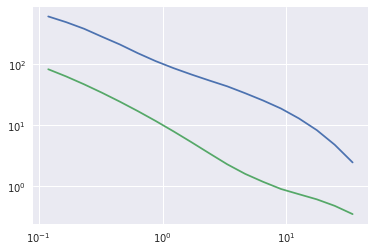

In [167]:
plt.plot(emu.scale_bin_centers, true_data[0])
plt.plot(emu.scale_bin_centers, true_data[1])

plt.loglog();

In [168]:
rbc = emu.scale_bin_centers#[-len(emu.scale_bin_centers):]

In [169]:
cov = f['cov'][()]
yerr = np.sqrt(np.diag(cov)).reshape((len(emus), -1))

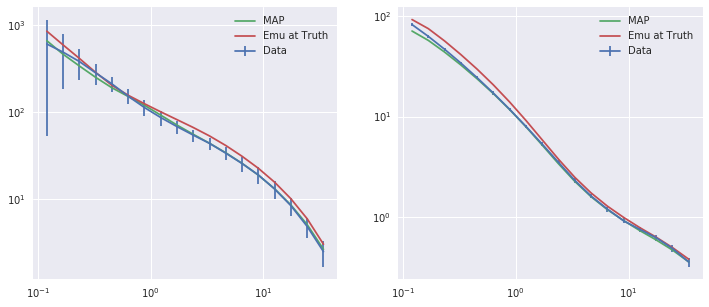

In [170]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, true_data[i], yerr=yerr[i], label = 'Data')
    plt.plot(rbc, 10**MAP_pred[i], label = 'MAP')
    plt.plot(rbc, 10**true_pred, label = 'Emu at Truth')

    plt.loglog()
    plt.legend(loc='best')
plt.show();

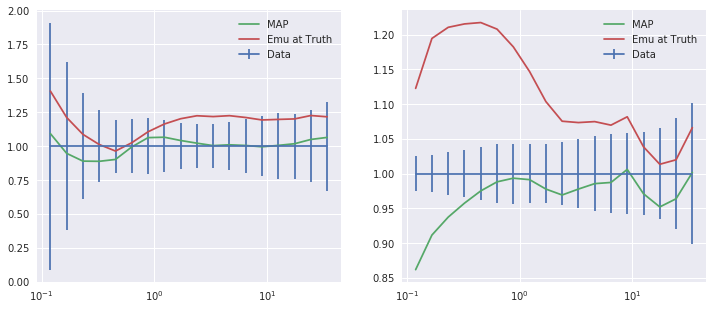

In [171]:
fig = plt.figure(figsize = (12,5))
for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    true_pred = emus[i].emulate_wrt_r(true_param_dict).squeeze()
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    plt.plot(rbc, (10**MAP_pred[i])/true_data[i], label = 'MAP')
    plt.plot(rbc, (10**true_pred)/true_data[i], label = 'Emu at Truth')
    plt.legend(loc='best')
    plt.xscale('log')
plt.show();

In [172]:
emu.obs

'ds'

In [173]:
rbc

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [174]:
npart_aemulus = 1400**3
npart_mdpl2 = 3840**3

downsample_factor = 1e-2
npart_aemulus_ds = npart_aemulus*downsample_factor
print npart_aemulus_ds, npart_aemulus_ds/npart_mdpl2

27440000.0 0.000484607837818


In [175]:
chain_pnames

array(['ombh2', 'omch2', 'w0', 'ns', 'H0', 'Neff', 'sigma8',
       'mean_occupation_centrals_assembias_param1',
       'mean_occupation_satellites_assembias_slope1', 'logM0',
       'sigma_logM', 'mean_occupation_satellites_assembias_param1',
       'mean_occupation_centrals_assembias_slope1', 'logM1', 'alpha',
       'conc_gal_bias'], dtype='|S43')

In [176]:
true_pred = np.hstack([emu.emulate_wrt_r(true_param_dict, r_bin_centers=emu.scale_bin_centers).squeeze() for emu in emus])
true_pred = true_pred.reshape((len(emus), -1))

In [177]:
rmin_idxs = rbc > rmin

In [178]:
cov_rmin_idxs = np.r_[rmin_idxs, rmin_idxs]

In [179]:
print 'True Red. Chi2'
R = (10**true_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

True Red. Chi2
4.829046191657492


In [180]:
print 'Map Red. Chi2'
R = (10**MAP_pred[:, rmin_idxs].flatten()-true_data[:, rmin_idxs].flatten())

chi2 =  R.T.dot(inv(cov[cov_rmin_idxs][:,cov_rmin_idxs])).dot(R)
dof = len(chain_pnames)

print chi2/dof

Map Red. Chi2
2.8676903705302044


In [181]:
N = 10
cmap = sns.color_palette("BrBG_d", N)

In [182]:
emu.get_param_names()

['ombh2',
 'omch2',
 'w0',
 'ns',
 'H0',
 'Neff',
 'sigma8',
 'mean_occupation_centrals_assembias_param1',
 'mean_occupation_satellites_assembias_slope1',
 'logM0',
 'sigma_logM',
 'mean_occupation_satellites_assembias_param1',
 'mean_occupation_centrals_assembias_slope1',
 'logM1',
 'alpha',
 'conc_gal_bias']

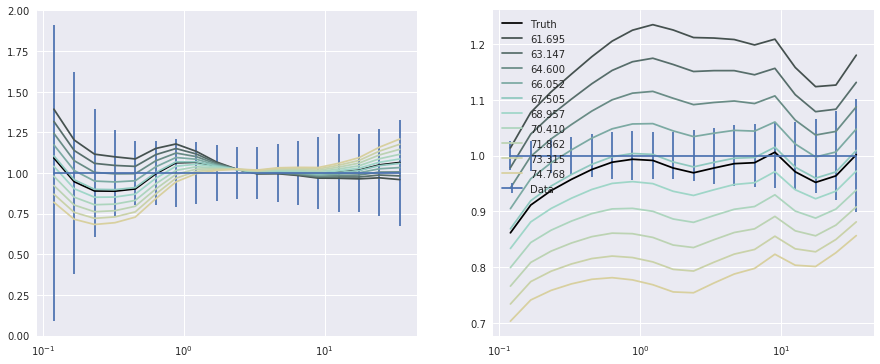

In [200]:
fig = plt.figure(figsize=(15,6))
varied_pname = 'H0'
lower, upper = emu.get_param_bounds(varied_pname)

for i in xrange(len(emus)):
    plt.subplot(1,2,i+1)
    plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i], label = 'Data')
    pred = emus[i].emulate_wrt_r(MAP_dict.copy()).squeeze()
    plt.plot(rbc, (10**pred)/true_data[i], label = 'Truth', color = 'k')    

    plt.xscale('log')
    
for c, val in zip(cmap, np.linspace(lower, upper, N) ):
    param_dict = MAP_dict.copy() #true_param_dict.copy()
    param_dict[varied_pname] = val

    for i in xrange(len(emus)):
        plt.subplot(1,2,i+1)
        pred = emus[i].emulate_wrt_r(param_dict).squeeze()
        plt.plot(rbc, (10**pred)/true_data[i], label = '%.3f'%val, color = c)
    
plt.legend(loc='best')
plt.show();

In [184]:
emu_avg = 10**(emus[1].y.mean(axis=(0,1))+emu._y_mean)

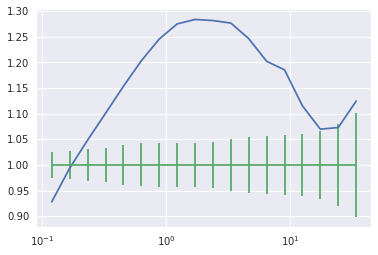

In [185]:
plt.plot(rbc, emu_avg/true_data[1])
plt.errorbar(rbc, np.ones_like(true_data[i]), yerr=yerr[i]/true_data[i])
plt.xscale('log')

In [186]:
cat.load(1.0, HOD='zheng07', particles=True)

most_recent_01_1_particle_2.00


In [187]:
from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, cat, nd = 5e-4):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(hod_params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (hod_params,),\
                          options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [188]:
add_logMmin(hod_params, cat)

logMmin 13.046854840222343


In [189]:
cat.populate(hod_params, min_ptcl = 20)

In [190]:
r_bins = np.logspace(-1, 1.6, 19)

In [191]:
print (r_bins[1:]+r_bins[:-1])/2.0

[ 0.11972916  0.16697228  0.23285675  0.32473812  0.45287435  0.63157098
  0.88077831  1.22831868  1.71299265  2.38891086  3.33153507  4.646103
  6.47937742  9.03603121 12.60149776 17.5738377  24.50817968 34.17869685]


In [192]:
emu.scale_bin_centers

array([ 0.11972916,  0.16697228,  0.23285675,  0.32473812,  0.45287435,
        0.63157098,  0.88077831,  1.22831868,  1.71299265,  2.38891085,
        3.33153506,  4.646103  ,  6.47937742,  9.03603121, 12.60149776,
       17.5738377 , 24.50817968, 34.17869685])

In [193]:
r_bins

array([ 0.1       ,  0.13945832,  0.19448624,  0.27122726,  0.37824899,
        0.52749971,  0.73564225,  1.02591437,  1.43072299,  1.99526231,
        2.7825594 ,  3.88051073,  5.41169527,  7.54705957, 10.52500285,
       14.67799268, 20.46968272, 28.54667663, 39.81071706])

In [194]:
[ 0.1,  0.13945832,  0.19448624,  0.27122726,  0.37824899,
                0.52749971,  0.73564225,  1.02591437,  1.43072299,  1.99526231,
                2.7825594 ,  3.88051073,  5.41169527,  7.54705957, 10.52500285,
                14.67799268, 20.46968272, 28.54667663, 39.81071706]

[0.1,
 0.13945832,
 0.19448624,
 0.27122726,
 0.37824899,
 0.52749971,
 0.73564225,
 1.02591437,
 1.43072299,
 1.99526231,
 2.7825594,
 3.88051073,
 5.41169527,
 7.54705957,
 10.52500285,
 14.67799268,
 20.46968272,
 28.54667663,
 39.81071706]